# Prediction




Predicting the outcomes of football matches—specifically wins, draws, or losses—has long been a central challenge in sports analytics. This project investigates whether match outcomes in the English Premier League (EPL) can be accurately predicted using team-level performance metrics derived from historical data. By framing the task as a multiclass classification problem, my research explores four machine learning models of increasing complexity: logistic regression, decision tree, k-nearest neighbors (KNN), and a neural network. The models are trained and evaluated on engineered features that capture differences in offensive performance, shot quality, and tactical pressure between competing teams. Among the models tested, the neural network consistently delivered the most balanced performance across outcome categories, achieving the highest macro F1-score and demonstrating improved prediction of underrepresented results such as losses. These findings suggest that incorporating non-linear modeling and modern deep learning techniques enhances the capacity to capture nuanced match dynamics and provides more equitable outcome predictions—offering actionable insights for analysts and teams alike.


**Data Preparation**

In [65]:
from sklearn.datasets import fetch_openml
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

*(1) Load the dataset*

In [66]:
### Fetch the dataset using OpenML ID
df = fetch_openml(data_id=43655, as_frame=True)['data']
display(df)

,Unnamed:_0,Date,League,Home_Team,Away_Team,Home_Chance_%,Draw_Chance_%,Away_Chance_%,Home_Goals,Away_Goals,...,Home_Shots,Away_Shots,Home_Shots_on_Target,Away_Shots_on_Target,Home_Deep,Away_Deep,Home_PPDA,Away_PPDA,Home_Expected_Points,Away_Expected_Points
0,0,'Aug 08 2015',EPL,'Manchester United',Tottenham,28,40,32,1,0,...,9,9,1,4,4,10,13.83,8.22,1.25,1.35
1,1,'Aug 08 2015',EPL,Bournemouth,'Aston Villa',36,35,29,0,1,...,11,7,2,3,11,2,6.90,11.85,1.42,1.23
2,2,'Aug 08 2015',EPL,Everton,Watford,30,43,27,2,2,...,10,11,5,5,5,4,6.65,17.16,1.33,1.24
3,3,'Aug 08 2015',EPL,Leicester,Sunderland,64,21,15,4,2,...,19,11,8,5,5,6,10.88,9.56,2.13,0.66
4,4,'Aug 08 2015',EPL,Norwich,'Crystal Palace',15,21,64,1,3,...,17,11,6,7,5,10,5.74,10.63,0.65,2.13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10786,10786,'Mar 08 2020',EPL,Chelsea,Everton,79,17,0,4,0,...,17,3,11,1,9,3,12.71,19.09,2.55,0.29
10787,10787,'Mar 07 2020',EPL,'Crystal Palace',Watford,46,37,17,1,0,...,10,10,3,3,10,7,10.32,5.84,1.74,0.89
10788,10788,'Mar 09 2020',EPL,Leicester,'Aston Villa',82,0,0,4,0,...,15,4,7,1,8,2,5.38,13.22,2.60,0.27
10789,10789,'Mar 07 2020',EPL,Liverpool,Bournemouth,52,28,20,2,1,...,14,6,6,4,9,3,4.75,20.29,1.85,0.88


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10791 entries, 0 to 10790
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed:_0            10791 non-null  int64  
 1   Date                  10791 non-null  object 
 2   League                10791 non-null  object 
 3   Home_Team             10791 non-null  object 
 4   Away_Team             10791 non-null  object 
 5   Home_Chance_%         10791 non-null  int64  
 6   Draw_Chance_%         10791 non-null  int64  
 7   Away_Chance_%         10791 non-null  int64  
 8   Home_Goals            10791 non-null  int64  
 9   Away_Goals            10791 non-null  int64  
 10  Home_Expected_Goals   10791 non-null  float64
 11  Away_Expected_Goals   10791 non-null  float64
 12  Home_Shots            10791 non-null  int64  
 13  Away_Shots            10791 non-null  int64  
 14  Home_Shots_on_Target  10791 non-null  int64  
 15  Away_Shots_on_Targe

In [68]:
### Filter for Premier League ("EPL") matches only
df_epl = df[df['League'] == "EPL"]

### Further filter for data up to "2019-05-12" (End of the 18-19 season)
df_date = df_epl[df_epl['Date'] <= "2019-05-12"]

### Sort the filtered dataset by Date in ascending order
df_order = df_date.sort_values(by='Date', ascending=True)

### Reset index for cleaner display
df_filtered = df_order.reset_index(drop=True)

### Drop the unwanted column (adjust column name if necessary)
df_filtered_final = df_filtered.drop(columns=['Unnamed:_0'], errors='ignore')

### Clean team names by removing extra quotes and spaces
df_filtered_final['Home_Team'] = df_filtered_final['Home_Team'].str.strip().str.replace("'", "")
df_filtered_final['Away_Team'] = df_filtered_final['Away_Team'].str.strip().str.replace("'", "")

### Display the cleaned dataset
display(df_filtered_final)

,Date,League,Home_Team,Away_Team,Home_Chance_%,Draw_Chance_%,Away_Chance_%,Home_Goals,Away_Goals,Home_Expected_Goals,...,Home_Shots,Away_Shots,Home_Shots_on_Target,Away_Shots_on_Target,Home_Deep,Away_Deep,Home_PPDA,Away_PPDA,Home_Expected_Points,Away_Expected_Points
0,'Apr 01 2017',EPL,Chelsea,Crystal Palace,74,16,0,1,2,3.17,...,24,8,11,3,26,4,4.43,13.29,2.38,0.46
1,'Apr 01 2017',EPL,Watford,Sunderland,80,15,0,1,0,1.96,...,23,11,10,3,9,1,6.89,11.82,2.56,0.29
2,'Apr 01 2017',EPL,Southampton,Bournemouth,0,21,66,0,0,1.00,...,14,12,4,3,7,4,10.38,15.65,0.60,2.19
3,'Apr 01 2017',EPL,Manchester United,West Bromwich Albion,58,35,0,0,0,0.99,...,18,3,3,1,8,3,4.13,22.63,2.09,0.56
4,'Apr 01 2017',EPL,Liverpool,Everton,0,25,62,3,1,0.63,...,10,9,6,4,3,5,6.75,10.86,0.63,2.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2180,'Sep 30 2017',EPL,Bournemouth,Leicester,59,29,0,0,0,1.40,...,19,8,4,1,18,1,11.00,11.00,2.06,0.65
2181,'Sep 30 2017',EPL,West Ham,Swansea,47,45,0,1,0,0.69,...,9,6,4,1,0,0,11.44,8.33,1.85,0.70
2182,'Sep 30 2017',EPL,Chelsea,Manchester City,26,32,42,0,1,0.91,...,4,17,2,6,2,8,36.73,7.90,1.11,1.57
2183,'Sep 30 2018',EPL,Cardiff,Burnley,80,18,0,1,2,1.57,...,20,3,5,2,14,6,6.18,6.92,2.58,0.24


In [69]:
df = df_filtered_final.drop(columns=['Unnamed:_0'], errors='ignore')

*(2) Define Target Variable*

In [70]:
def get_result(row):
    if row['Home_Goals'] > row['Away_Goals']:
        return 'Win'
    elif row['Home_Goals'] < row['Away_Goals']:
        return 'Loss'
    else:
        return 'Draw'

df['Match_Result'] = df.apply(get_result, axis=1)

*(3) Create Relative Feature Columns*

In [71]:
df['xG_Diff'] = df['Home_Expected_Goals'] - df['Away_Expected_Goals']
df['Shots_on_Target_Diff'] = df['Home_Shots_on_Target'] - df['Away_Shots_on_Target']
df['Shots_Diff'] = df['Home_Shots'] - df['Away_Shots']
df['PPDA_Diff'] = df['Away_PPDA'] - df['Home_PPDA']  ### lower value = higher pressing
df['Deep_Diff'] = df['Home_Deep'] - df['Away_Deep']
df['ExpectedPoints_Diff'] = df['Home_Expected_Points'] - df['Away_Expected_Points']
df['Chance_%_Diff'] = df['Home_Chance_%'] - df['Away_Chance_%']

*xG_Diff*: Difference in expected goals

*Shots_Diff and Shots_on_Target_Diff*: Differences in total and accurate shooting

*PPDA_Diff*: Difference in pressing intensity (where lower = more aggressive pressing)

*Deep_Diff*: Difference in deep attacking entries

*ExpectedPoints_Diff and Chance_%_Diff*: Differences in projected outcomes and chance creation

*(4) Select Final Features and Target*

In [72]:
features = [
    'xG_Diff',
    'Shots_on_Target_Diff',
    'Shots_Diff',
    'PPDA_Diff',
    'Deep_Diff',
    'ExpectedPoints_Diff',
    'Chance_%_Diff'
]

X = df[features]
y = df['Match_Result']

*(5) Encode Target Variable*

In [73]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)  ### Convert target classes (Win/Draw/Loss) to numeric values

*(6) Train-Test Split*

In [74]:
### Split features and target into training and test sets (80/20), preserving class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

*(7) Feature Scaling (Standardization)*

In [75]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  ### Fit to training data and transform it
X_test_scaled = scaler.transform(X_test)        ### Use the same transformation on test data

**Evaluation Metric**

In this project, the task of predicting football match outcomes (Win, Draw, Loss) constitutes a multiclass classification problem with a moderately imbalanced class distribution. Although accuracy is a widely used evaluation metric, it can be misleading in this context. A model may achieve high accuracy by consistently predicting the most frequent class—typically wins—yet perform poorly on less frequent but equally critical outcomes such as draws or losses. This imbalance poses a challenge for fair performance assessment.

To ensure a more meaningful and balanced evaluation, I adopt the macro-averaged F1-score as the primary metric across all models. The F1-score integrates both precision (the proportion of predicted positives that are correct) and recall (the proportion of actual positives that are correctly predicted), offering a more nuanced view of classification performance. The macro-average further enhances fairness by treating each class equally, regardless of its frequency. This is particularly relevant in sports analytics, where identifying less common but impactful results—such as unexpected losses or tightly contested draws—can yield valuable insights for teams, coaches, and analysts.

By prioritizing macro F1-score, I establish a consistent and equitable standard for comparing model performance across different algorithmic approaches, including logistic regression, decision trees, KNN, and neural networks. While supporting metrics such as accuracy, confusion matrices, and per-class precision and recall are also reported to aid interpretation, the macro F1-score remains the most appropriate measure for this imbalanced, multiclass setting. Its emphasis on class-level balance ensures that model effectiveness is not overstated by majority-class dominance and better reflects real-world predictive utility.

**Model 1: Logistic Regression**

In [76]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

*(1) Train Logistic Regression & Predict*

In [77]:
### Initialize a logistic regression model with specified solver and settings
logreg = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42)

### Fit the model on the training data
logreg.fit(X_train_scaled, y_train)

### Predict match outcomes on the test data
y_pred_logreg = logreg.predict(X_test_scaled)

*(2) Evaluation*

1. Calculate Accuracy Score

In [78]:
accuracy = accuracy_score(y_test, y_pred_logreg)
print("Accuracy Score:", accuracy)

Accuracy Score: 0.6292906178489702


2. Generate Confusion Matrix

In [79]:
conf_matrix = confusion_matrix(y_test, y_pred_logreg)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[  7  34  64]
 [  7  97  28]
 [  8  21 171]]


3. Print classification report

In [80]:
report = classification_report(y_test, y_pred_logreg)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.32      0.07      0.11       105
           1       0.64      0.73      0.68       132
           2       0.65      0.85      0.74       200

    accuracy                           0.63       437
   macro avg       0.54      0.55      0.51       437
weighted avg       0.57      0.63      0.57       437



*(3) Visualization*

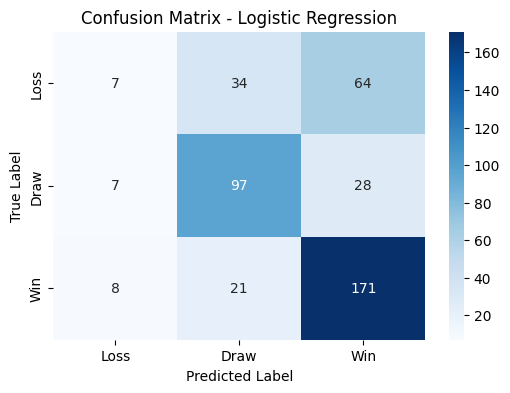

In [81]:
### Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_logreg)

### Define class labels
labels = ['Loss', 'Draw', 'Win']

### Create a heatmap for the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

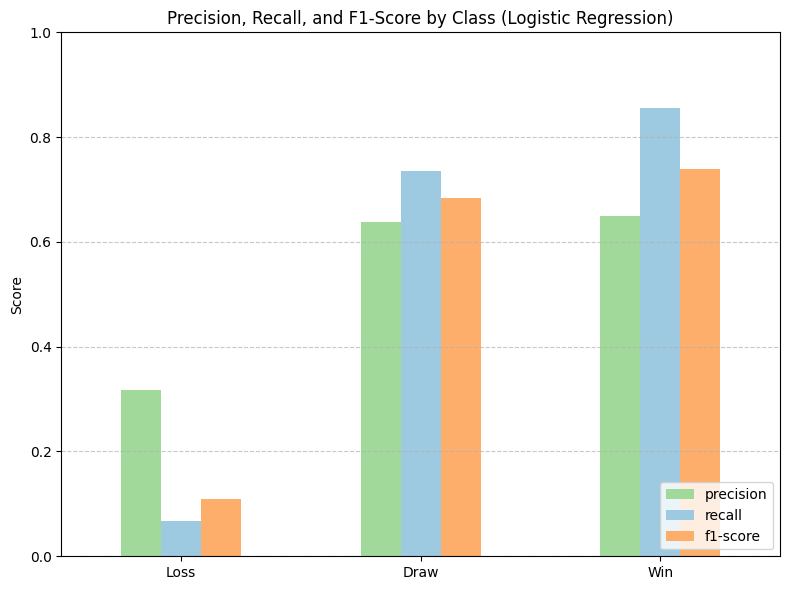

In [82]:
### Get classification report as dictionary
report_dict = classification_report(y_test, y_pred_logreg, output_dict=True)

### Convert to DataFrame and clean
report_df = pd.DataFrame(report_dict).transpose()
class_metrics = report_df.loc[['0', '1', '2'], ['precision', 'recall', 'f1-score']]
class_metrics.index = ['Loss', 'Draw', 'Win']

### Plot
colors = ['#a1d99b', '#9ecae1', '#fdae6b']  # Light green, blue, orange
class_metrics.plot(kind='bar', figsize=(8, 6), color=colors)
plt.title('Precision, Recall, and F1-Score by Class (Logistic Regression)')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

*(4) Feature Contribution Analysis*

In [83]:
### Feature names and coefficients per class
import numpy as np
coeff_df = pd.DataFrame(logreg.coef_, columns=X.columns, index=['Loss', 'Draw', 'Win'])
print(coeff_df.T)

                          Loss      Draw       Win
xG_Diff               0.176479 -1.541170  1.364691
Shots_on_Target_Diff  0.005966 -0.870435  0.864469
Shots_Diff            0.030886  0.814080 -0.844966
PPDA_Diff            -0.017678  0.053416 -0.035738
Deep_Diff             0.051739 -0.111159  0.059419
ExpectedPoints_Diff  -0.420165 -0.050637  0.470802
Chance_%_Diff         0.267225  0.292370 -0.559595


**Model 2: Decision Tree**

In [84]:
from sklearn.tree import DecisionTreeClassifier

*(1) Initialize*

In [85]:
### Initialize the decision tree classifier
dtree = DecisionTreeClassifier(random_state=42)

*(2) Train the Model*

In [86]:
### Fit the model on the training data
dtree.fit(X_train_scaled, y_train)

DecisionTreeClassifier(random_state=42)

*(3) Make Predictions*

In [87]:
### Predict outcomes on the test data
y_pred_dtree = dtree.predict(X_test_scaled)

*(4) Evaluation*

1. Calculate Accuracy Score

In [88]:
### Calculate Accuracy Score
accuracy_dtree = accuracy_score(y_test, y_pred_dtree)
print("Accuracy Score:", accuracy_dtree)

Accuracy Score: 0.505720823798627


2. Confusion Matrix

In [89]:
### Generate Confusion Matrix
conf_matrix_dtree = confusion_matrix(y_test, y_pred_dtree)
print("Confusion Matrix:\n", conf_matrix_dtree)

Confusion Matrix:
 [[ 31  31  43]
 [ 39  67  26]
 [ 45  32 123]]


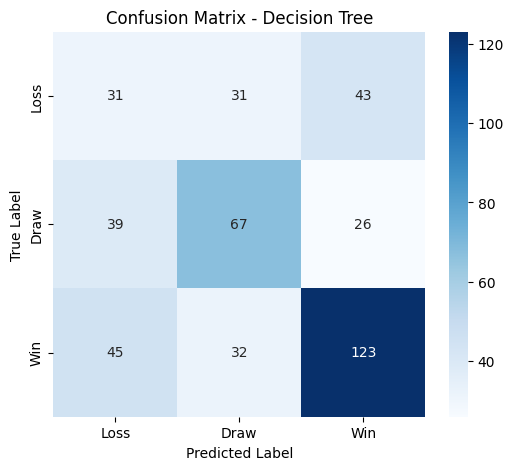

In [90]:
### Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_dtree, annot=True, fmt="d", cmap="Blues", xticklabels=["Loss", "Draw", "Win"], yticklabels=["Loss", "Draw", "Win"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Decision Tree")
plt.show()

3. Classification Report

In [91]:
### Print Classification Report
report_dtree = classification_report(y_test, y_pred_dtree, digits=2)
print("Classification Report:\n", report_dtree)

Classification Report:
               precision    recall  f1-score   support

           0       0.27      0.30      0.28       105
           1       0.52      0.51      0.51       132
           2       0.64      0.61      0.63       200

    accuracy                           0.51       437
   macro avg       0.48      0.47      0.47       437
weighted avg       0.51      0.51      0.51       437



In [92]:
### Extract metrics for plotting
report_dict = classification_report(y_test, y_pred_dtree, output_dict=True)
df_metrics = pd.DataFrame(report_dict).transpose().loc[['0', '1', '2'], ['precision', 'recall', 'f1-score']]
df_metrics.index = ['Loss', 'Draw', 'Win']

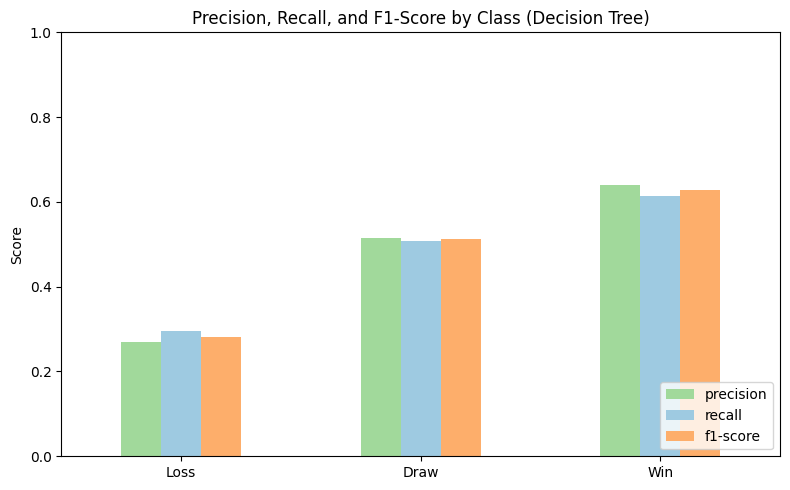

In [93]:
### Plot
colors = ['#a1d99b', '#9ecae1', '#fdae6b']
df_metrics.plot(kind='bar', figsize=(8, 5), color=colors)
plt.title("Precision, Recall, and F1-Score by Class (Decision Tree)")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

*(5) Visualize the Tree*

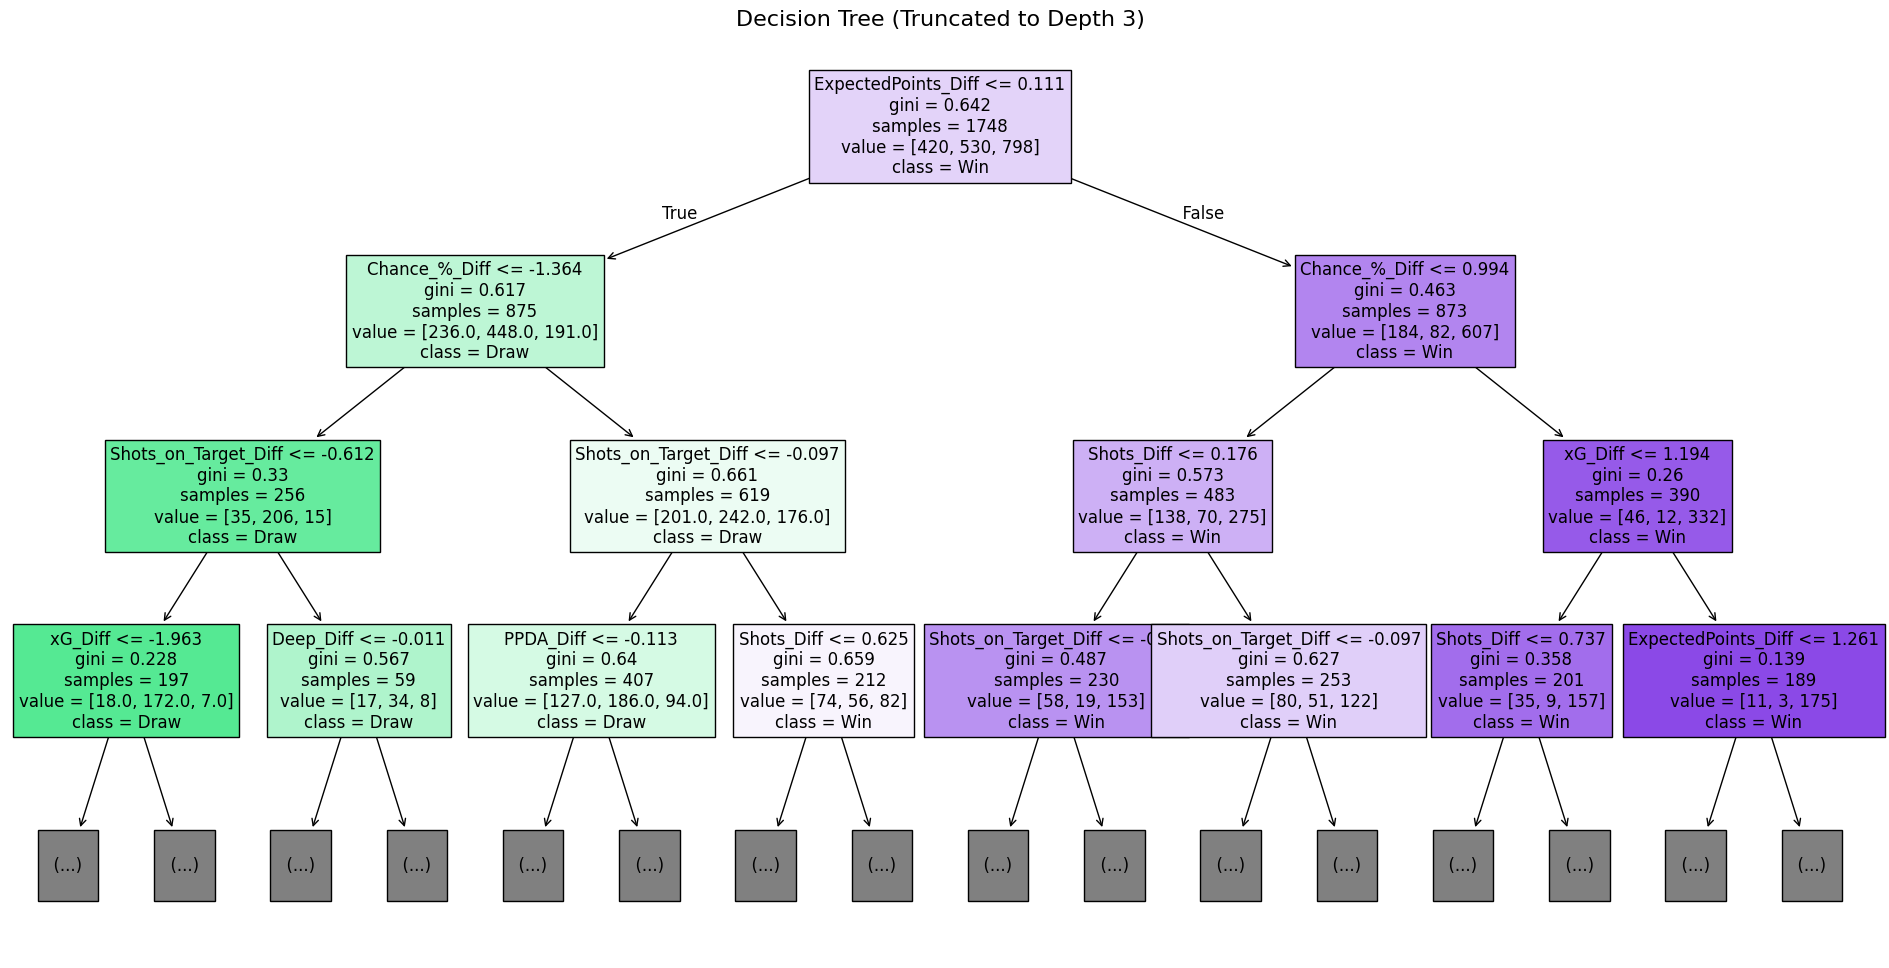

In [94]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(24, 12))
plot_tree(dtree,
          feature_names=X.columns,
          class_names=['Loss', 'Draw', 'Win'],
          filled=True,
          max_depth=3,
          fontsize=12)
plt.title("Decision Tree (Truncated to Depth 3)", fontsize=16)
plt.show()

**Model 3: k-Nearest Neighbors (KNN)**

In [95]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

*(1) Define the Hyperparameter Grid*

In [96]:
### Define a grid of hyperparameters to search
param_grid = {
    'n_neighbors': list(range(3, 21)),  # Try K from 3 to 20
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

*(2) Set Up and Run GridSearchCV*

In [97]:
### Initialize base KNN model
knn = KNeighborsClassifier()

### Perform grid search with 5-fold cross-validation and macro F1-score
grid_search_knn = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1
)

### Fit on the training data
grid_search_knn.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                         14, 15, 16, 17, 18, 19, 20],
                         'weights': ['uniform', 'distance']},
             scoring='f1_macro')

*(3) Retrieve and Print the Best Parameters*

In [98]:
### Get the best model and parameters
best_knn = grid_search_knn.best_estimator_
best_params = grid_search_knn.best_params_

print("Best Parameters:", best_params)

Best Parameters: {'metric': 'euclidean', 'n_neighbors': 20, 'weights': 'uniform'}


*(4) Use the Tuned Model for Predictions*

In [99]:
### Predict on the test set using the best KNN model
y_pred_knn = best_knn.predict(X_test_scaled)

*(5) Evaluation*

1. Calculate Accuracy Score

In [100]:
### Accuracy Score
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print("Accuracy Score:", accuracy_knn)

Accuracy Score: 0.585812356979405


2. Confusion Matrix

In [101]:
### Confusion Matrix
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)
print("Confusion Matrix:\n", conf_matrix_knn)

Confusion Matrix:
 [[ 18  32  55]
 [ 24  82  26]
 [ 20  24 156]]


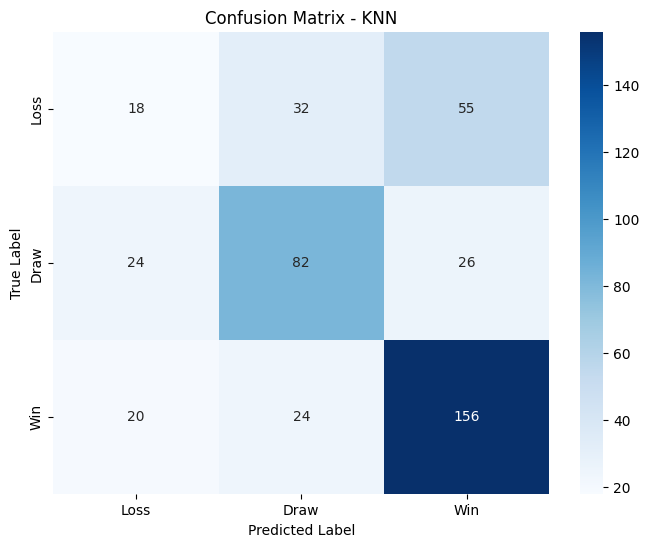

In [102]:
### Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_knn, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Loss', 'Draw', 'Win'], yticklabels=['Loss', 'Draw', 'Win'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - KNN')
plt.show()

3. Classification Report

In [103]:
### Classification Report
report_knn = classification_report(y_test, y_pred_knn)
print("Classification Report:\n", report_knn)

Classification Report:
               precision    recall  f1-score   support

           0       0.29      0.17      0.22       105
           1       0.59      0.62      0.61       132
           2       0.66      0.78      0.71       200

    accuracy                           0.59       437
   macro avg       0.51      0.52      0.51       437
weighted avg       0.55      0.59      0.56       437



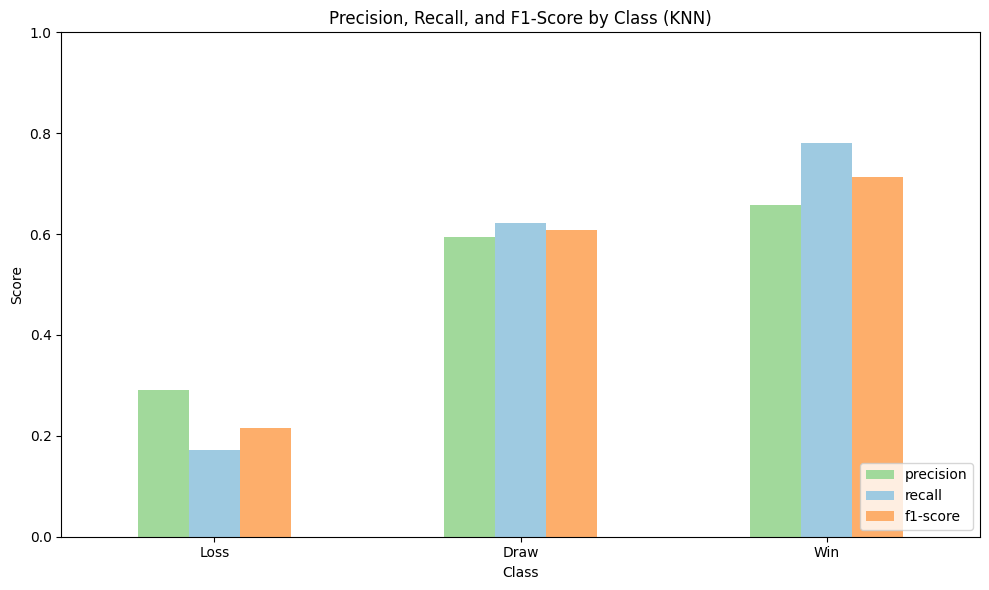

In [104]:
### Get classification report
report_dict = classification_report(y_test, y_pred_knn, output_dict=True)

### Convert and clean
df_report = pd.DataFrame(report_dict).transpose().loc[['0', '1', '2'], ['precision', 'recall', 'f1-score']]
df_report.index = ['Loss', 'Draw', 'Win']

### Plot
colors = ['#a1d99b', '#9ecae1', '#fdae6b']
df_report.plot(kind='bar', figsize=(10, 6), color=colors)
plt.title("Precision, Recall, and F1-Score by Class (KNN)")
plt.xlabel("Class")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

**Model 4: Neural Network**

In [105]:
!pip install tensorflow

In [106]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam

*(1) Encode Target Variables*

In [107]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

y_train_cat = to_categorical(y_train_encoded)
y_test_cat = to_categorical(y_test_encoded)

*(2) Compute Class Weights (to handle imbalance)*

In [108]:
class_weights_array = compute_class_weight(class_weight='balanced',
                                           classes=np.unique(y_train_encoded),
                                           y=y_train_encoded)
class_weights = dict(enumerate(class_weights_array))

*(3) Build the Model*

In [109]:
### Define improved model architecture
model = Sequential()
model.add(Input(shape=(X_train_scaled.shape[1],)))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax'))  ### 3 output classes: Win, Draw, Loss

*(4) Compile the Model*

In [110]:
### Compile the model with Adam optimizer and categorical cross-entropy loss
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

*(5) Train the Model with Early Stopping*

In [111]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train_scaled, y_train_cat,
                    validation_split=0.2,
                    epochs=100,
                    batch_size=32,
                    callbacks=[early_stop],
                    class_weight=class_weights,
                    verbose=1)

Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.4229 - loss: 1.2366 - val_accuracy: 0.5971 - val_loss: 0.9929
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5156 - loss: 1.0203 - val_accuracy: 0.4914 - val_loss: 0.9834
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5743 - loss: 0.9335 - val_accuracy: 0.4714 - val_loss: 0.9800
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5879 - loss: 0.8893 - val_accuracy: 0.4943 - val_loss: 0.9451
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5778 - loss: 0.8911 - val_accuracy: 0.5114 - val_loss: 0.9269
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5707 - loss: 0.8954 - val_accuracy: 0.5343 - val_loss: 0.8958
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5916 - loss: 0.8988 - val_accuracy: 0.5943 - val_loss: 0.8555
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5795 - loss: 0.8840 - val_accuracy: 0.61

*(6) Evaluate Predictions*

In [112]:
y_pred_prob = model.predict(X_test_scaled)
y_pred = y_pred_prob.argmax(axis=1)
y_true = y_test_encoded

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


*(7) Evaluation*

1. Calculate Accuracy

In [113]:
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy Score:", accuracy)

Accuracy Score: 0.5949656750572082


2. Confusion Matrix

Confusion Matrix:
 [[ 51  27  27]
 [ 33  89  10]
 [ 60  20 120]]


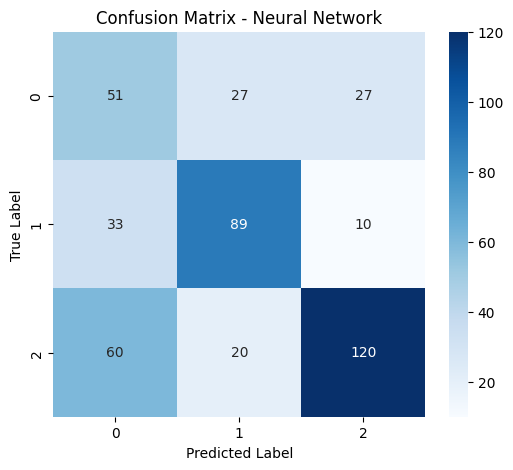

In [114]:
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", conf_matrix)

### Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Neural Network")
plt.show()

3. Classification Report

In [115]:
### Convert numeric class labels to strings
target_names = [str(class_label) for class_label in label_encoder.classes_]

### Generate classification report with proper target names
report = classification_report(y_true, y_pred, target_names=target_names)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.35      0.49      0.41       105
           1       0.65      0.67      0.66       132
           2       0.76      0.60      0.67       200

    accuracy                           0.59       437
   macro avg       0.59      0.59      0.58       437
weighted avg       0.63      0.59      0.61       437



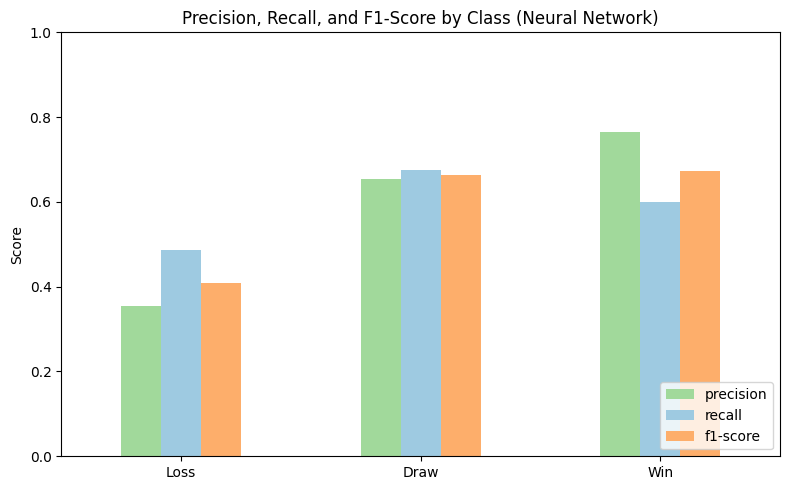

In [116]:
### Get classification report
report_dict = classification_report(y_true, y_pred, target_names=label_encoder.classes_, output_dict=True)

### Convert and clean
scores_df = pd.DataFrame(report_dict).transpose().iloc[:3, :3]
scores_df.index = ['Loss', 'Draw', 'Win']

### Plot
colors = ['#a1d99b', '#9ecae1', '#fdae6b']
scores_df[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(8, 5), color=colors)
plt.title("Precision, Recall, and F1-Score by Class (Neural Network)")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

**Model Summary**

To evaluate which model best predicts football match outcomes (Win, Draw, Loss) based on team-level statistics, four classification models were developed and compared: Logistic Regression, Decision Tree, K-Nearest Neighbors (KNN), and a Neural Network. Each model was assessed primarily using macro-averaged F1-score, a metric that ensures equal consideration for each outcome class, making it especially appropriate for our moderately imbalanced dataset. Complementary metrics such as accuracy and class-wise F1-scores were also examined.
The figure below (Figure 18) provides a consolidated view of each model’s overall performance, including its accuracy, macro F1-score, and which outcome classes it performed best and worst at:

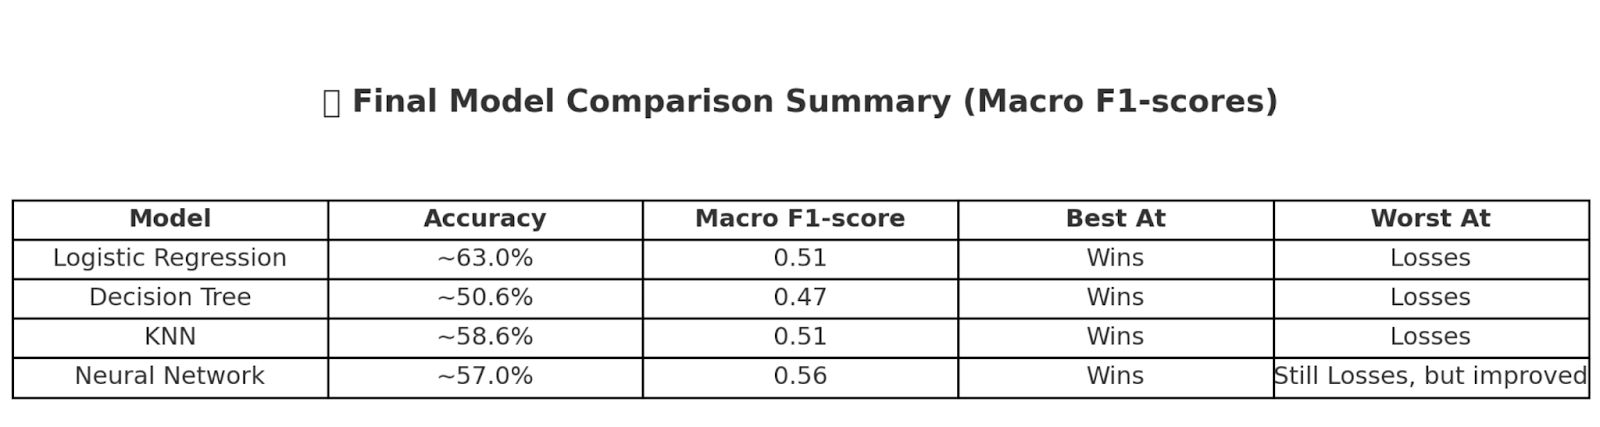

As the summary table shows, the Neural Network model achieved the highest macro F1-score (0.56), outperforming other models in overall balanced predictive performance. While all models were most successful at identifying wins, the Neural Network showed relative improvement in identifying losses, which had been the weakest class across earlier models. This result suggests that the non-linear capabilities and deeper structure of neural networks allow them to better capture complex patterns in the input features.
From a strategic standpoint, this reinforces the value of using more flexible, non-linear models when predicting nuanced outcomes in competitive sports, especially when interest extends beyond majority class outcomes (i.e., wins) to rarer but equally important results like draws and losses.
Thus, based on both fairness across classes and predictive quality, the Neural Network model is selected as the best-performing classifier for this football match prediction task.

**Limitations and Future Steps**

While the neural network model achieved the best performance among all classifiers, several limitations in the current approach suggest room for improvement. The dataset primarily consists of team-level aggregated statistics such as xG difference and PPDA, which, although informative, do not capture critical contextual factors like red cards, player injuries, or tactical substitutions that may drastically influence match outcomes. Moreover, the models do not account for temporal patterns or seasonal momentum—treating matches as independent observations rather than part of a dynamic sequence. Additionally, while class imbalance was partially addressed through the use of macro F1-score and class weighting, predicting losses remained a persistent weakness, especially in simpler models.
Looking forward, future work could integrate richer data sources, including play-by-play actions, player-level stats, and contextual features, to enhance model inputs. Incorporating time-series modeling could also help capture trends in team performance over time. More extensive hyperparameter tuning and the use of ensemble methods might further optimize predictive accuracy. Lastly, applying interpretability tools such as SHAP or LIME to the neural network would help bridge the gap between model performance and transparency—an important consideration in practical sports analytics applications.